## Initialization

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import List, Literal, Tuple


@dataclass
class Parameter:
    name: str
    data: np.ndarray
    grad: np.ndarray


class Module:
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
        
    def forward(self, *args, **kwargs):
        raise NotImplementedError

    def backward(self, *args, **kwargs):
        raise NotImplementedError
    
    def parameters(self) -> List[Parameter]:
        return []

    def zero_grad(self):
        for param in self.parameters():
            param.grad.fill(0)


# Define a custom type alias for initialization methods
InitMethod = Literal["xavier", "he", "he_leaky", "normal", "uniform"]

def parameter(
    input_size: int,
    output_size: int,
    init_method: InitMethod = "xavier",
    gain: float = 1,
    alpha: float = 0.01
) -> np.ndarray:
    weights = np.random.randn(input_size, output_size)

    if init_method == "xavier":
        std = gain * np.sqrt(1.0 / input_size)
        return std * weights
    if init_method == "he":
        std = gain * np.sqrt(2.0 / input_size)
        return std * weights
    if init_method == "he_leaky":
        std = gain * np.sqrt(2.0 / (1 + alpha**2) * (1 / input_size))
        return std * weights
    if init_method == "normal":
        return gain * weights
    if init_method == "uniform":
        return gain * np.random.uniform(-1, 1, size=(input_size, output_size))

    raise ValueError(f"Unknown initialization method: {init_method}")


class Linear(Module):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        init_method: InitMethod = "xavier"
    ):
        self.input: np.ndarray = None

        self.weights: np.ndarray = parameter(input_size, output_size, init_method)
        self.d_weights: np.ndarray = np.zeros_like(self.weights)

        self.biases: np.ndarray = np.zeros((1, output_size))
        self.d_biases: np.ndarray = np.zeros_like(self.biases)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        x1 = x @ self.weights + self.biases
        return x1
    
    def backward(self, d_out: np.ndarray) -> np.ndarray:
        self.d_weights = self.input.T @ d_out
        self.d_biases = np.sum(d_out, axis=0, keepdims=True)

        return d_out @ self.weights.T

    def parameters(self):
        return [
            Parameter(
                name="weights",
                data=self.weights,
                grad=self.d_weights
            ),
            Parameter(
                name="biases",
                data=self.biases,
                grad=self.d_biases
            ),
        ]


class BCELoss(Module):
    def forward(
        self, pred: np.ndarray, target: np.ndarray, epsilon: float = 1e-7
    ) -> np.ndarray:        
        loss = -(
            target * np.log(pred + epsilon) + 
            (1 - target) * np.log(1 - pred + epsilon)
        )

        return np.mean(loss)

    def backward(
        self, pred: np.ndarray, target: np.ndarray, epsilon: float = 1e-7
    ) -> np.ndarray:
        grad = (pred - target) / (pred * (1 - pred) + epsilon)
        return grad


class Sigmoid(Module):
    def forward(self, x: np.ndarray):
        # Apply the Sigmoid function element-wise
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, d_out: np.ndarray):
        # Derivative of the Sigmoid function: sigmoid * (1 - sigmoid)
        ds = self.output * (1 - self.output)
        return d_out * ds


class LeakyReLU(Module):
    def __init__(self, alpha: float = 0.01):
        self.alpha = alpha

    def forward(self, x: np.ndarray):
        self.input = x
        return np.where(x > 0, x, self.alpha * x)

    def backward(self, d_out: np.ndarray):
        dx = np.ones_like(self.input)
        dx[self.input < 0] = self.alpha
        return d_out * dx


class Sequential(Module):
    def __init__(self, layers: List[Module]):
        self.layers = layers

    def forward(self, x: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, d_out: np.ndarray, lr: float = 0.001) -> np.ndarray:
        for layer in reversed(self.layers):
            d_out = layer.backward(d_out)
        return d_out

    def parameters(self) -> List[Parameter]:
        params = []
        for i, layer in enumerate(self.layers):
            for param in layer.parameters():
                # Add unique prefix name for optimization step
                param.name = f"layer_{i}_{param.name}"
                params.append(param)
        return params


class SGD:
    def __init__(
        self,
        lr: float = 0.01,
        momentum: float = 0.0,
        clip_value: float = 1.0
    ):
        self.lr = lr
        self.momentum = momentum
        self.clip_value = clip_value
        self.velocity = {}

    def step(self, module: Module):
        for param in module.parameters():
            param_id = param.name

            # Init velocity if not exists
            if param_id not in self.velocity:
                self.velocity[param_id] = np.zeros_like(param.data)

            grad = param.grad.copy()

            # Gradient cliping
            if self.clip_value > 0:
                np.clip(grad, -self.clip_value, self.clip_value, out=grad)

            # Update momentum
            self.velocity[param_id] = (
                self.momentum * self.velocity[param_id] +
                (1 - self.momentum) * grad
            )

            # Update parameters
            param.data -= self.lr * self.velocity[param_id]



## Fashion-MNIST

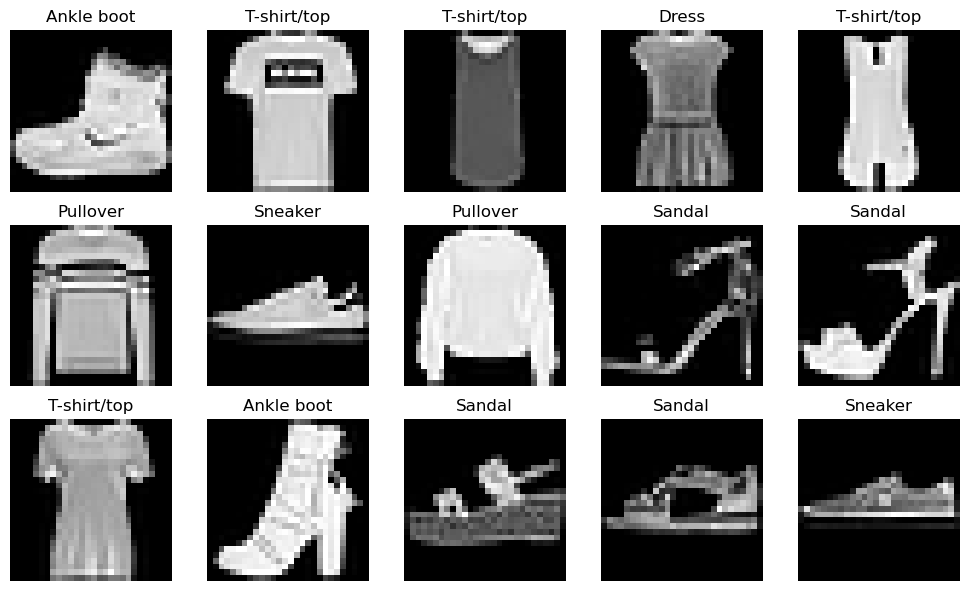

In [29]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Fetch the Fashion MNIST dataset from OpenML
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)

# Separate the features (images) and labels
X, y = fashion_mnist['data'], fashion_mnist['target']

# Convert labels to integers (since OpenML may return them as strings)
y = y.astype(int)


# Define label names for Fashion MNIST classes
label_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Plot some sample images
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
axes = axes.ravel()

for i in range(15):
    img = X[i].reshape(28, 28)  # Reshape the 1D array into a 28x28 image
    axes[i].imshow(img, cmap='gray')  # Display in grayscale
    axes[i].set_title(label_names[y[i]])  # Set label as title
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [30]:
from sklearn.model_selection import train_test_split

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

X_train.shape, X_test.shape

((56000, 784), (14000, 784))

In [31]:
# Convert labels to one-hot encoding
num_classes = 10

y_train_one_hot = np.eye(num_classes)[y_train]
y_test_one_hot = np.eye(num_classes)[y_test]

## Data preprocessing

In [32]:
from sklearn.preprocessing import MinMaxScaler

# Rescale
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## CrossEntropyLoss and Softmax

### Cross-Entropy Loss

$$L = -\sum_{i} y_i \log(S_i)$$

and its gradient **after softmax** is simply:

$$\frac{\partial L}{\partial z} = S - y$$

In [33]:
class CrossEntropyLoss(Module):
    def forward(self, pred: np.ndarray, target: np.ndarray, eps: float = 1e-7):
        pred = np.clip(pred, eps, 1.0 - eps)
        loss = -np.sum(target * np.log(pred), axis=1)
        return np.mean(loss)
    
    def backward(self, pred: np.ndarray, target: np.ndarray, eps: float = 1e-7):
        pred = np.clip(pred, eps, 1.0 - eps)
        grad = pred - target
        return grad

### Softmax

$$S_i = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$$

But with the Cross-Entropy its derivative: 

$$\frac{\partial L}{\partial z_i} = S_i \left( d_{\text{out}_i} - \sum_j d_{\text{out}_j} S_j \right)$$

In [34]:
class Softmax(Module):
    def forward(self, x: np.ndarray):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.output
    
    def backward(self, d_out: np.ndarray):
        return self.output * (d_out - np.sum(d_out * self.output, axis=1, keepdims=True))

## Build a model with SGD

In [35]:
input_dims = 784

model = Sequential([
    Linear(input_dims, input_dims, init_method="he_leaky"),
    LeakyReLU(),
    Linear(input_dims, 256, init_method="he_leaky"),
    LeakyReLU(),
    Linear(256, 128, init_method="he_leaky"),
    LeakyReLU(),
    Linear(128, 10, init_method="he_leaky"),
    Softmax()
])

ce_loss = CrossEntropyLoss()
optimizer = SGD(lr=0.01, momentum=0.9)

## Training loop

In [37]:
# Hyperparameters
epochs = 20
batch_size = 128

for epoch in range(epochs):
    indices = np.random.permutation(X_train.shape[0])
    X_train_shuffled, y_train_shuffled = X_train[indices], y_train_one_hot[indices]

    total_loss = 0
    num_batches = X_train.shape[0] // batch_size

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]

        # Forward pass
        pred = model(X_batch)
        loss = ce_loss(pred, y_batch)

        # Zero grad!
        model.zero_grad()

        # Backward pass
        d_loss = ce_loss.backward(pred, y_batch)
        model.backward(d_loss)

        # Update weights
        optimizer.step(model)

        total_loss += loss

    # Compute avg loss
    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/20, Loss: 0.6390
Epoch 2/20, Loss: 0.4264
Epoch 3/20, Loss: 0.3772
Epoch 4/20, Loss: 0.3631
Epoch 5/20, Loss: 0.3396
Epoch 6/20, Loss: 0.3292
Epoch 7/20, Loss: 0.3159
Epoch 8/20, Loss: 0.3036
Epoch 9/20, Loss: 0.2969
Epoch 10/20, Loss: 0.2877
Epoch 11/20, Loss: 0.2782
Epoch 12/20, Loss: 0.2725
Epoch 13/20, Loss: 0.2665
Epoch 14/20, Loss: 0.2591
Epoch 15/20, Loss: 0.2570
Epoch 16/20, Loss: 0.2516
Epoch 17/20, Loss: 0.2477
Epoch 18/20, Loss: 0.2380
Epoch 19/20, Loss: 0.2408
Epoch 20/20, Loss: 0.2300


In [ ]:
from sklearn.metrics import accuracy_score

y_pred = model(X_train)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_train, y_pred_labels)

print(f"Train Accuracy: {accuracy * 100:.2f}%")

Train Accuracy: 93.40%


In [ ]:
y_pred = model(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_labels)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 89.41%
